## Accelerate Sensitivity Analysis & Model Calibration Using pyGSFLOW


<img src = "./figures/WorkFlow.PNG">





### Notebook contents

This notebook demonstrates some basic model analysis, sensitivity analysis, and calibration techniques for individual parameters: The notebook shows how to:
* Create simple plots of PRMS parameter data
* Adjust PRMS parameter data by scalar factors
* Adjust PRMS parameter data using zones to create conditional masks
* Simple sensitivity analysis
* Simple calibration


Let's start by loading the Sagehen GSFLOW model

In [1]:
import os
from gsflow import GsflowModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
## The GSFLOW model is loaded as follows
control_file = os.path.join(".", "data", "sagehen", "gsflow", "saghen_new_cont.control")
gsf = GsflowModel.load_from_file(control_file)

Control file is loaded
Working on loading PRMS model ...
Prms model loading ...
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_0.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_1.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_2.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_3.params
------------------------------------
PRMS model loaded ...
Working on loading MODFLOW files ....
   loading iuzfbnd array...
   loading irunbnd array...
   loading vks a

## Create simple plots of PRMS parameter data

In this section we'll use matplotlib to create very simple plots of PRMS parameter data. For more complex plots, and to define the discretization and geographic coordinates of the grid, please see the notebook titled `pygsflow_discretization_and_plotting.ipynb`

Let's start by getting the ssr2gw_rate parameter and plotting it using matplotlib. The ssr2gw_parameter has the dimension of "nhru" which is equivalent to the number of cells in a single layer of the model.

In [3]:
params = gsf.prms.parameters
ssr2gw_rate = gsf.prms.parameters.get_values("ssr2gw_rate")

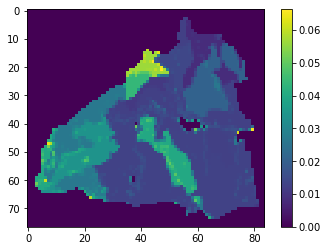

In [4]:
# reshape the parameter values to the model grid's shape
nrow = gsf.mf.modelgrid.nrow
ncol = gsf.mf.modelgrid.ncol
ssr2gw_rate.shape = (nrow, ncol)

plt.imshow(ssr2gw_rate)
plt.colorbar();

In this example "rain_adj" is plotted. Rain adj has two PRMS dimensions, "nhru" and "nmonths". This is equivalent to the number of cells in a single layer of the model * 12. We can reshape this to produce a map each month

In [5]:
# get and print rain_adj to see the dimensions.
rain_adj = gsf.prms.parameters.get_record('rain_adj')
print(rain_adj)


####
rain_adj 10
2
nhru
nmonths
77616
2
1.223373
1.214444
1.205549
1.196689.
.
.
####


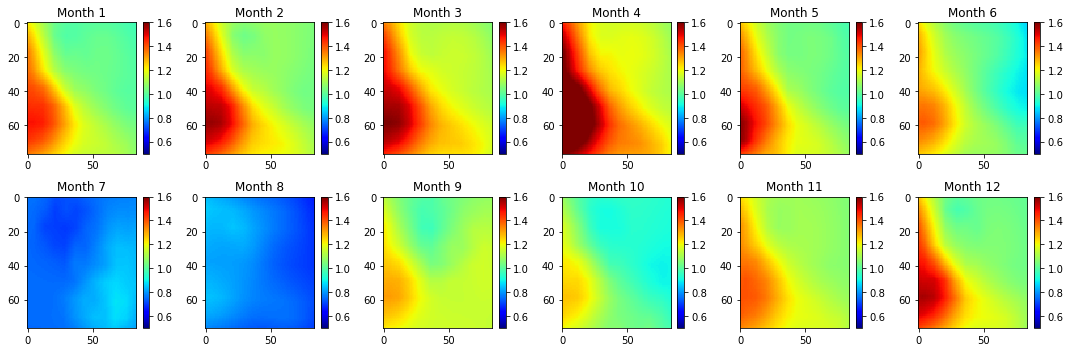

In [6]:
# plot each month of the rain_adj parameter in its own subplot
rain_adj = rain_adj.values.reshape(12, nrow, ncol)

fig = plt.figure(figsize=(15,5)); 
for mon in range(12): 
    txt = f"Month {mon + 1}"
    ax = plt.subplot(2, 6, mon + 1) 
    ax.set_title(txt)
    img = ax.imshow(rain_adj[mon, :, :], cmap='jet', vmin=0.5, vmax=1.6)
    
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    
plt.tight_layout(h_pad=1);

## Adjust PRMS parameters by scalar factors

In this example, we'll compare two model runs. This section includes:

   - Running the model without adjusting parameters
   - Running the model after adjusting the rain_adj and snow_adj factors. 
   - Comparing basin flow results from each of the model runs. 

**Note**: This example changes the model mode to "PRMS" becuase it's quick to run it. The same exercise can be made using GSFLOW model; however, runing the model will take a longer period of time

#### Running the model without adjustments

In [7]:
# reset model mode to PRMS
gsf.control.set_values("model_mode", ['PRMS'])

In [8]:
gsf.write_input(workspace=os.path.join(".", "data", "temp"))

Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...


In [9]:
gsf.gsflow_exe = os.path.abspath(os.path.join("..", "bin", "gsflow.exe"))
success, buff = gsf.run_model(silent=False)

pyGSFLOW is using the following executable to run the model: C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\bin\gsflow.exe


                          U.S. Geological Survey
        Coupled Groundwater and Surface-water FLOW model (GSFLOW)
                         Version 1.2.2 02/23/2018

    An integration of the Precipitation-Runoff Modeling System (PRMS)
    and the Modular Groundwater Model (MODFLOW-NWT and MODFLOW-2005)

 WARNING, map_results requested with nmapOutVars equal 0
 no map_results output is produced

Simulation time period: 1982/08/01 - 1997/03/31



                          Normal completion of GSFLOW

Execution start date and time (yyyy/mm/dd hh:mm:ss) 2021/12/30 13:35:42

Execution end   date and time (yyyy/mm/dd hh:mm:ss) 2021/12/30 13:35:52

Execution elapsed time    0 minutes  9.37 seconds










ERROR: parameter format error; file is saghen_new_par_0.params; line number 220180





         set in the Parameter File. Module default values are being used.

   

Now let's get data from the PRMS statistics file (StatVar file). We'll be comparing the basin cfs output from the two models

In [10]:
statvar = gsf.prms.get_StatVar()
statvar.head()

Loading the statvar output file .....
Finished Load the statvar output file .....


,ID,Year,Month,Day,Hour,Minute,Second,basin_cfs_1,basin_gwflow_cfs_1,basin_sroff_cfs_1,basin_dunnian_1,basin_ssflow_cfs_1,basin_ppt_1,basin_snow_1,basin_pweqv_1,basin_snowcov_1,basin_actet_1,basin_potsw_1,basin_recharge_1,Date
0,1,1982,8,1,0,0,0,1.646627,1.646627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005586,357.576387,0.0,1982-08-01
1,2,1982,8,2,0,0,0,1.617396,1.617396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001062,192.550774,0.0,1982-08-02
2,3,1982,8,3,0,0,0,1.588744,1.588744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001581,190.893375,0.0,1982-08-03
3,4,1982,8,4,0,0,0,1.560659,1.560659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001568,190.228080,0.0,1982-08-04
4,5,1982,8,5,0,0,0,1.533129,1.533129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003095,352.856858,0.0,1982-08-05


In [11]:
basic_cfs_before = statvar['basin_cfs_1'].values

#### Running the model after adjusting PRMS variables

In this section, the notebook shows how to adjust a parameter by a scalar value. The model is then run and results are stored for comparision with the previous model run.

We'll start by adjusting `rain_adj` and `snow_adj`

In [12]:
## save a copy of rain_adj before we change it
rain_adj0 = np.copy(gsf.prms.parameters.get_values('rain_adj'))
snow_adj0 = np.copy(gsf.prms.parameters.get_values('snow_adj'))

Adjust the parameters using a scalar factor. Let's remove the effect of precipitation by setting the "rain_adj" and "snow_adj" factors to 0.

In [13]:
gsf.prms.parameters.set_values('rain_adj', rain_adj0 * 0.0)
gsf.prms.parameters.set_values('snow_adj', snow_adj0 * 0.0);

In [14]:
# Write input files and run the model
gsf.write_input(workspace=os.path.join(".", "data", "temp", "prms_files"))
gsf.run_model();

Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...
pyGSFLOW is using the following executable to run the model: C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\bin\gsflow.exe


                          U.S. Geological Survey
        Coupled Groundwater and Surface-water FLOW model (GSFLOW)
                         Version 1.2.2 02/23/2018

    An integration of the Precipitation-Runoff Modeling System (PRMS)
    and the Modular Groundwater Model (MODFLOW-NWT and MODFLOW-2005)

 WARNING, map_results requested with nmapOutVars equal 0
 no map_results output is produced

Simulation time period: 1982/08/01 - 1997/03/31



                          Normal completion of GSFLOW

Execution start date and time (yyyy/mm/dd hh:mm:ss) 2021/12/30 13:35:54

Execution end   date and time (yyyy/mm/dd hh:mm:ss) 2021/12/30 13:35:59

Execution elapsed time    0 minutes  5.55 seconds










ERROR: para

Let's get results from the PRMS statistics (StatsVar) file

In [15]:
# Get results
statvar = gsf.prms.get_StatVar() 
basic_cfs_after = statvar['basin_cfs_1'].values

Loading the statvar output file .....
Finished Load the statvar output file .....


#### Comparing results from the two model runs

Because the "basin_cfs" ouput is a timeseries of data we can create a simple timeseries plot using matplotlib and visualize the differences between the two model runs. 

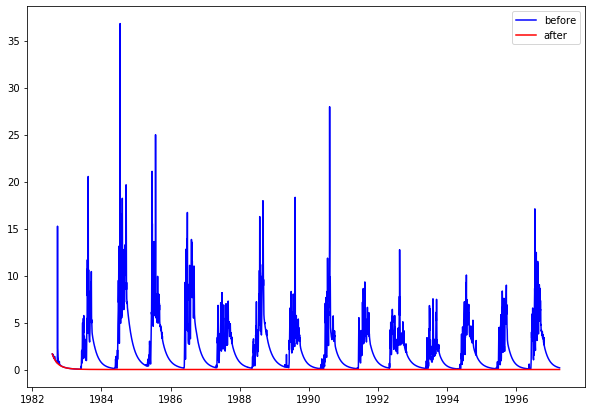

In [16]:
# Get the simulation dates from the statvar file
dates = statvar['Date'].values

# plot the results from the two models.
plt.figure(figsize=(10,7))
plt.plot(dates, (basic_cfs_before), 'b', label = 'before' )
plt.plot(dates,(basic_cfs_after), 'r', label = 'after' )
plt.legend();

## Adjust PRMS parameter data using zones to create conditional masks

The following examples demonstrate simple and more complex conditional masks that can be used to adjust PRMS parameters. We'll show how to:
   - mask and adjust parameter values by elevation
   - mask and adjust parameter values by subbasin
   - mask and adjust parameter values by subbasin and elevation using more complex masking


#### Mask and adjust parameter values by elevation

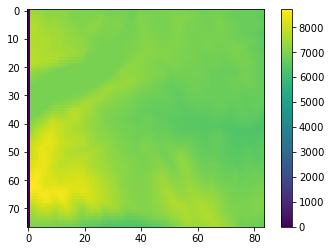

In [17]:
# 1st, let's get the elevations of each hru.
params = gsf.prms.parameters

hru_elev = params.get_values("hru_elev")
hru_elev.shape = (nrow, ncol)

plt.imshow(hru_elev)
plt.colorbar();

Let's create and view our mask

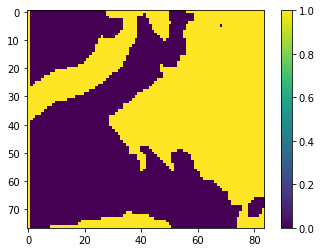

In [18]:
mask = np.where(hru_elev < 7000, True, False)
plt.imshow(mask.astype(int))
plt.colorbar();

And finally, let's use the mask to adjust January's rain_adj factor

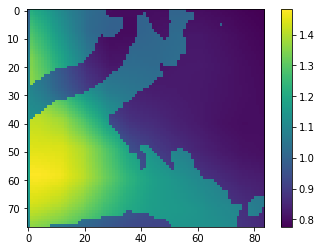

In [19]:
rain_adj_jan = rain_adj[0, :, :]
rain_adj_jan[mask] = rain_adj_jan[mask] * 0.8
plt.imshow(rain_adj_jan)
plt.colorbar();

#### Mask and adjust parameter values by subbasin

This example demonstrates how to change `ssr2_gw_rate` values in subbasin 10. This can be applied to any prms parameter variable and any subbasin or combination of subbasins.

Get the subbasin values and visualize them

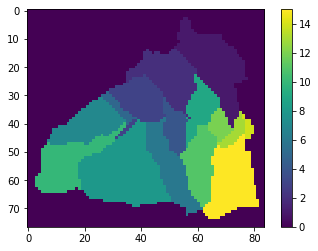

In [20]:
# subbasin values are stored in the UZF irunbnd array for this example
hru_subbasin = gsf.mf.uzf.irunbnd.array

plt.imshow(hru_subbasin)
plt.colorbar();

Get the ssr2gw_rate parameter and visualize it

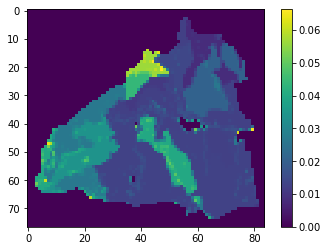

In [21]:
ssr2gw_rate = np.copy(params.get_values("ssr2gw_rate"))
ssr2gw_rate.shape = (nrow, ncol)
plt.imshow(ssr2gw_rate)
plt.colorbar();

Finally let's adjust the values of ssr2gw_rate in subbasin 10

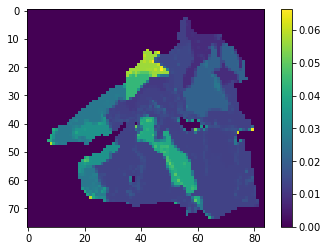

In [22]:
ssr2gw_rate[hru_subbasin==10] = ssr2gw_rate[hru_subbasin==10] * 0.0
plt.imshow(ssr2gw_rate)
plt.colorbar();

#### Mask and adjust parameter values by subbasin and elevation using more complex masking

Masks can also be complex and include multiple conditions. Here is a short example showing masking by subbasin and hru_elevation

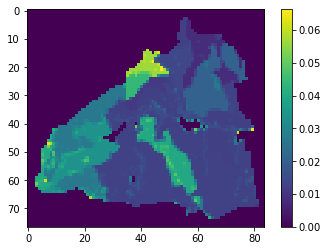

In [23]:
ssr2gw_rate = params.get_values("ssr2gw_rate").reshape(nrow, ncol)

# apply our adjustment
ssr2gw_rate = np.where((hru_subbasin == 10) & (hru_elev < 7200),
                       0,
                       ssr2gw_rate)

# The mask can also be complex 
# mask2 = np.logical_and(hru_subbasin==10, hru_elev <7500)
plt.imshow(ssr2gw_rate)
plt.colorbar();

## Simple sensitivity analysis


In this example the notebook demonstrates how to use pyGSFLOW to do simple senstivity analysis on PRMS parameters. This approach can also be used for Modflow parameters.

We'll first load a model and save a copy of the original parameter values. Then we adjust the parameters of insterest over a series of scaling factors to observe their relative sensitivities. 

#### Load model and save the original parameter values from the model.

In [24]:
# load model files
control_file = os.path.join(".", "data", "sagehen", "gsflow", "saghen_new_cont.control")
exe_name = os.path.join("..", "bin", "gsflow.exe")
gsf = GsflowModel.load_from_file(control_file, gsflow_exe=exe_name)

Control file is loaded
Working on loading PRMS model ...
Prms model loading ...
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_0.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_1.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_2.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_3.params
------------------------------------
PRMS model loaded ...
Working on loading MODFLOW files ....
   loading iuzfbnd array...
   loading irunbnd array...
   loading vks a

Let's us use PRMS for this demonstration, and turn off screen output to reduce clutter in the notebook

In [25]:
gsf.control.set_values("model_mode", ['PRMS'])
gsf.control.set_values("print_debug", [-1])
gsf.control.set_values(name='end_time', values=[1990,1,1,0,0,0])

Finally let's save the original parameter values to a dictionary for use in the next section

In [26]:
parameters = ['snarea_curve', 'ssr2gw_rate',  'gwflow_coef']
params = gsf.prms.parameters

# Save a copy of parameter values before we adjust them.
orig_params = {}
for par in parameters:
    orig_params[par] = np.copy(params.get_values(par))

#### Adjust parameter values over a range of scaling factors 

Now that the original values for the three parameters of interest have been saved, we can create a nested loop that loops over each parameter and a range of scaling factors to adjust them.

In the next code block we'll run 15 iterations of the model and store the mean outflow values in order to assess the sensitivity of streamflow to each parameter's values.

In [27]:
parameters = ['snarea_curve', 'ssr2gw_rate',  'gwflow_coef']
factors = [0.5, 0.75, 1.0, 1.25, 1.5]

# dictionary to store results
all_sens = {}

# loop over parameter names and scale factors
for par in parameters:
    responce = []
    for facc in factors:
        # adjust parameter values
        print(f"\n****** Parameter = {par}, Factor = {facc} ****** ")
        params.set_values(name=par, values=orig_params[par] * facc) 
        
        # write input files and run the model
        gsf.write_input(workspace=os.path.join(".", "data", "temp"))
        gsf.run_model(silent=True)
        
        # load and save mean streamflow from the stat var file
        statvar = gsf.prms.get_StatVar() 
        mean_outflow = statvar['basin_cfs_1'].mean()
        responce.append(mean_outflow)
    
    # store the results and reset parameter values to original values
    all_sens[par] = responce
    params.set_values(name=par, values=orig_params[par])



****** Parameter = snarea_curve, Factor = 0.5 ****** 
Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...
Loading the statvar output file .....
Finished Load the statvar output file .....

****** Parameter = snarea_curve, Factor = 0.75 ****** 
Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...
Loading the statvar output file .....
Finished Load the statvar output file .....

****** Parameter = snarea_curve, Factor = 1.0 ****** 
Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...
Loading the statvar output file .....
Finished Load the statvar output file .....

****** Parameter = snarea_curve, Factor = 1.25 ****** 
Writing the project files .....
Writing Control file ...
Writing Pa

Let's plot the results from our sensitivity analysis runs.

As we can see snrea_curve and ssr2gw_rate parameters are the more sensitive to adjustments then the gwflow_coef for this model.

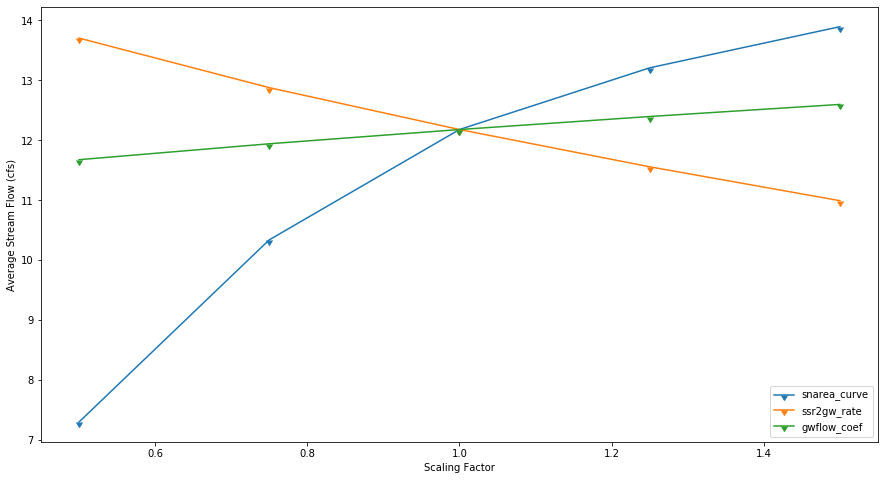

In [28]:
plt.figure(figsize=(15,8))
for par in all_sens.keys():
    plt.plot(factors, all_sens[par], label=par, marker=11)
plt.ylabel("Average Stream Flow (cfs)")
plt.xlabel("Scaling Factor")
plt.legend();

## Simple Calibration 

In this example the notebook presents a method for simple calibration and analysis of a GSFLOW model using pyGSFLOW. This section walks through a number of steps including:

   - Comparing simulated and observed data
   - Creating and applying error metrics
   - Using error metrics to perform simple calibration


Let's start by loading and running a fresh copy of the Sagehen GSFLOW model in PRMS mode. 

In [29]:
control_file = os.path.join(".", "data", "sagehen", "gsflow", "saghen_new_cont.control")
os.path.abspath(os.path.join("..", "bin", "gsflow.exe"))

# load model
gsf = GsflowModel.load_from_file(control_file, gsflow_exe=exe_name)

# set model mode to PRMS and turn off screen print out
gsf.control.set_values("model_mode", ['PRMS']) 
gsf.control.set_values("print_debug", [-1])
gsf.control.set_values(name='end_time', values=[1990,1,1,0,0,0])

# write input and run the model
gsf.write_input(workspace=os.path.join(".", "data", "temp"))
success, buff = gsf.run_model(silent=True);

Control file is loaded
Working on loading PRMS model ...
Prms model loading ...
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_0.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_1.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_2.params
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\gsflow\saghen_new_par_3.params
------------------------------------
PRMS model loaded ...
Working on loading MODFLOW files ....
   loading iuzfbnd array...
   loading irunbnd array...
   loading vks a

#### Compare simulated and observed data

In this section of the example we show how to access and compare simulated and oberved data from PRMS inputs and outputs over a time range.

Let's focus our analysis on streamflow values from 8/1/1982 through 1/11/1990

Loading the statvar output file .....
Finished Load the statvar output file .....


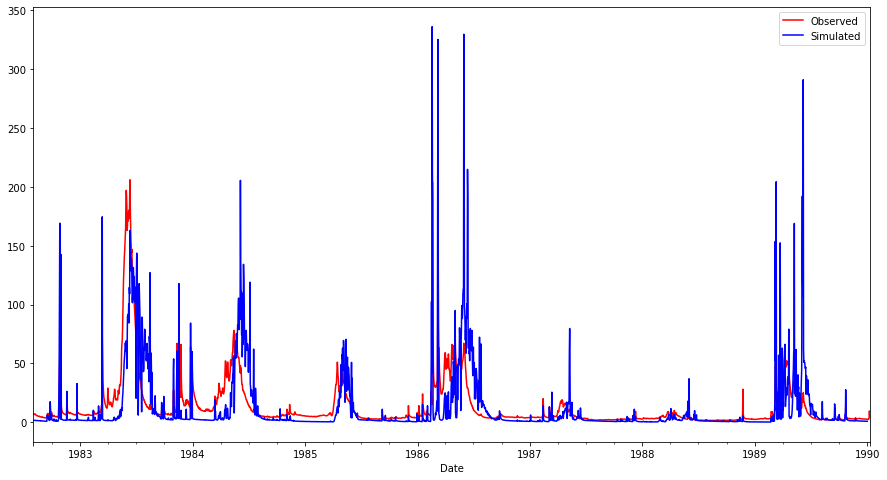

In [30]:
# Get streamflow measurements from the PRMS Data file
observed_df = gsf.prms.data.data_df 
mask = np.logical_and(
    observed_df['Date'] >= pd.Timestamp('1982-08-01'),  
    observed_df['Date'] <= pd.Timestamp('1990-01-11')
)
observed_data = observed_df[mask]


# get simulation results
simulated_df = gsf.prms.get_StatVar()

# plot simulated vs. measured flow
ax = observed_data.plot(x='Date' , y='runoff_0', color='r', label='Observed')
simulated_df.plot(ax=ax, x='Date' , y='basin_cfs_1', color='b', label='Simulated', figsize=(15,8))
plt.legend();

We can aslo calculate mean monthly values using built in methods in pandas.


In [31]:
# Calculate mean monthly streamflow using the groupby method in pandas
monthly_obs = observed_data.groupby(by=[observed_data.Date.dt.year, observed_data.Month]).mean()
monthly_sim = simulated_df.groupby(by=[simulated_df.Date.dt.year, simulated_df.Month]).mean()
monthly_sim

ID    Year   Day  Hour  Minute  Second  basin_cfs_1  \
Date Month                                                            
1982 8        16.0  1982.0  16.0   0.0     0.0     0.0     1.328095   
     9        46.5  1982.0  15.5   0.0     0.0     0.0     3.111892   
     10       77.0  1982.0  16.0   0.0     0.0     0.0    17.549967   
     11      107.5  1982.0  15.5   0.0     0.0     0.0     2.724143   
     12      138.0  1982.0  16.0   0.0     0.0     0.0     2.961555   
...            ...     ...   ...   ...     ...     ...          ...   
1989 9      2603.5  1989.0  15.5   0.0     0.0     0.0     2.925966   
     10     2634.0  1989.0  16.0   0.0     0.0     0.0     3.373464   
     11     2664.5  1989.0  15.5   0.0     0.0     0.0     1.296687   
     12     2695.0  1989.0  16.0   0.0     0.0     0.0     0.910071   
1990 1      2711.0  1990.0   1.0   0.0     0.0     0.0     0.774551   

            basin_gwflow_cfs_1  basin_sroff_cfs_1  basin_dunnian_1  \
Date Month                                                           
1982 8                1.280977           0.014195         0.000050   
     9                0.769352           0.619970         0.002118   
     10               0.629335          13.252631         0.046284   
     11               1.272282           0.630483         0.001268   
     12               1.504467           0.882995         0.002629   
...                        ...                ...              ...   
1989 9                1.390044           0.380592         0.001299   
     10               1.055201           0.668174         0.002291   
     11               0.997263           0.048744         0.000166   
     12               0.856795           0.001019         0.000003   
1990 1                0.759746           0.001041         0.000003   

            basin_ssflow_cfs_1  basin_ppt_1  basin_snow_1  basin_pweqv_1  \
Date Month                                                                 
1982 8                0.032924     0.006439      0.000000       0.000000   
     9                1.722570     0.182316      0.017424       0.022891   
     10               3.668001     0.249184      0.052347       0.334860   
     11               0.821378     0.286797      0.269122       3.288344   
     12               0.574093     0.301502      0.275903      12.739985   
...                        ...          ...           ...            ...   
1989 9                1.155329     0.114707      0.008624       0.014968   
     10               1.650088     0.163833      0.043578       0.308464   
     11               0.250680     0.100027      0.094686       1.484855   
     12               0.052257     0.000000      0.000000       3.590923   
1990 1                0.013764     0.045431      0.043895       3.577265   

            basin_snowcov_1  basin_actet_1  basin_potsw_1  basin_recharge_1  
Date Month                                                                   
1982 8             0.000000       0.012405     613.629988          0.000000  
     9             0.080277       0.028284     424.251899          0.002183  
     10            0.349280       0.028299     227.001342          0.026650  
     11            0.939767       0.006183     121.450203          0.050205  
     12            0.999981       0.001514      85.286850          0.027095  
...                     ...            ...            ...               ...  
1989 9             0.028571       0.050242     469.645940          0.010763  
     10            0.282140       0.035540     254.766311          0.015013  
     11            0.617804       0.022267     191.654488          0.018978  
     12            0.997970       0.003163     135.222392          0.009446  
1990 1             1.000000       0.000716      71.341179          0.006674  

[90 rows x 18 columns]

Now we can plot the mean montly values and compare observed vs. simulated data

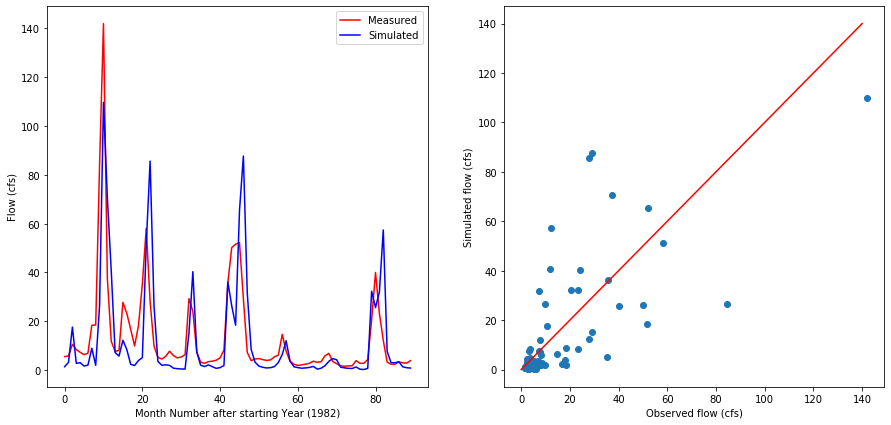

In [32]:
# Plots
plt.figure(figsize=(15,7))

# timeseries plot
plt.subplot(1,2,1)
plt.plot(monthly_obs['runoff_0'].values, 'r', label = 'Measured')
plt.plot(monthly_sim['basin_cfs_1'].values, 'b', label = 'Simulated')
plt.xlabel("Month Number after starting Year (1982)")
plt.ylabel("Flow (cfs)")
plt.legend()

# 1 to 1 plot
plt.subplot(1,2,2)
plt.scatter(monthly_obs['runoff_0'].values, monthly_sim['basin_cfs_1'].values)
plt.plot([0,140], [0,140], 'r')
plt.xlabel("Observed flow (cfs)")
plt.ylabel("Simulated flow (cfs)");

#### Create an error metric to apply in calibration

This example shows how to create a simple method that returns the mean squared error of the simulated streamflow values. The user can adjust this method or create their own to assess other measurements of model error (ex. RMSE, MAE, nash sutcliffe values, etc...)

In [33]:
def calculate_error(gsf_obj):
    """
    This function calculates mean squared error for simulated stream flow.
    
    Parameters
    ==========
    gsf_obj : gsflow.GsflowModel object
    
    Returs
    ======
        mean squared error of simulated stream flow
    """
    observed_data = gsf_obj.prms.data.data_df
    
    # Get data for simulated period
    mask = np.logical_and(
        observed_data['Date']>=pd.Timestamp('1982-08-01'), 
        observed_data['Date']<=pd.Timestamp('1990-01-01')
    )    
    observed_data = observed_data[mask]
    
    # get simulated values
    simulated_data = gsf_obj.prms.get_StatVar()
    # compute error
    err = simulated_data['basin_cfs_1'].values - observed_data['runoff_0'].values
    # compute mean squared error
    mse = np.mean(err ** 2.0) ** 0.5
    return mse

#### Using the error metric to perform simple calibration

In this section we put the pieces together from the last two and apply the mean squared error metric to perform a simple calibration experiment. 

For this example, we change one parameter at a time. This method can be useful when input parameters are independent. More advanced techniques are needed if input parameters are highly coorelated.  

<img src = ".\figures\calibration_cycle.PNG">

Let's start by using the parameters that we stored in the Sensitivy Analysis section of this notebook.

In [34]:
orig_params.keys()

dict_keys(['snarea_curve', 'ssr2gw_rate', 'gwflow_coef'])

Now let's put together the calibration experiment loop. This loop will cycle through each parameter and a series of scale factors to run 21 iterations of the model. For each model iteration we can save the mean squared error values for calibration analysis

In [35]:
parameters = ['gwflow_coef', 'snarea_curve', 'ssr2gw_rate']
factors = [ 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
all_errors = {}
for par in parameters:    
    errors = []
    for facc in factors:
        print(f"\n****** Parameter = {par}, Factor = {facc} ****** ")
        
        # apply the scale factor and adjust input parameter values
        gsf.prms.parameters.set_values(name=par, values=orig_params[par] * facc)
        
        # write input files and run the model
        gsf.write_input(workspace=os.path.join(".", "data", "temp"))
        gsf.run_model(silent=True) 
        
        # calculate the and save the mean squared error
        err = calculate_error(gsf)
        errors.append(err)
    
    # store the errors for all runs and reset the parameter to it's original value
    all_errors[par] = errors
    gsf.prms.parameters.set_values(name=par, values=orig_params[par])


****** Parameter = gwflow_coef, Factor = 0.75 ****** 
Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...
Loading the statvar output file .....
Finished Load the statvar output file .....

****** Parameter = gwflow_coef, Factor = 1.0 ****** 
Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...
Loading the statvar output file .....
Finished Load the statvar output file .....

****** Parameter = gwflow_coef, Factor = 1.25 ****** 
Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...
Loading the statvar output file .....
Finished Load the statvar output file .....

****** Parameter = gwflow_coef, Factor = 1.5 ****** 
Writing the project files .....
Writing Control file ...
Writing Parame

Now we can plot the MSE for each parameter through the range of scale factor values to determine 1) the sensitivity of the parameter to change, and 2) how to adjust each of the parameters to reduce model error.

In this example, the greatest reduction in MSE can be accomplished by scaling the ssr2gw_rate parameter by a factor of 2.25

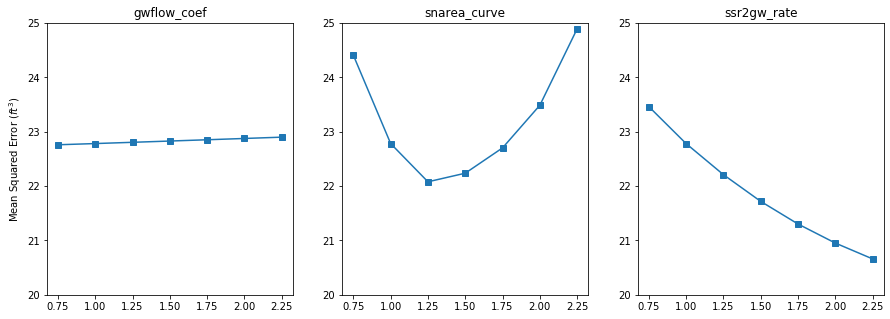

In [36]:
plt.figure(figsize=(15,5))
i = 1
for par in all_errors.keys():
    plt.subplot(1, 3, i)
    plt.plot(factors, all_errors[par], label = par, marker='s')
    if i == 1:
        plt.ylabel("Mean Squared Error " + r"$(ft^{3})$")
    i += 1
    plt.ylim([20, 25])
    plt.title(par)

plt.show();

#### Reminder: This calibration method is usefull only if input parameters are independent. In external calibration software, parameters can be changed and evaluated concurrently.

pygsflow can be used to change parameters in conjuction with analysis by external calibration software, however that application is beyond the scope of what can be represented in jupyter notebooks.